<a href="https://colab.research.google.com/github/qlin1996/NYC_Property_Sales/blob/master/NYC_Property_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Have some cash on hand and thinking about investing in NYC real estate? Or maybe you have a property and you're thinking about getting rid of it? Whether you decide to buy or sell property, be sure to this report before making a decision.

In this report, I analyze New York City Department of Finance's NYC property sales of years 2016-2019 for trends in property location, property demand and sale prices. The specific questions I answer are:

*   What boroughs sold the most property and at what price?
*   What neigbhorhoods sold the most properties and at what price?
*   What were hottest buildings? How much did each building class cost in each borough?
*   What affects sale price? Is there a correlation between sale price and land sq ft, gross sq feet, or the year in which the property was built?

# Housekeeping

## Import Libraries, Read Data, and Set Style

In [0]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [883]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
full_data = pd.read_csv('/content/drive/My Drive/NYC_Citywide_Annualized_Calendar_Sales_Update.csv')
sns.set(context= 'notebook', style='ticks', palette='muted', font='sans-serifs', font_scale=1.2, color_codes=True, rc={'lines.linewidth': 1.75, 'figure.figsize': (9, 6)})

## Raw Data

## Data Dictionary

**BOROUGH**\
**NEIGHBORHOOD**\
**BUILDING CLASS**: Identifies properties broad usage (e.g. One Family Home).\
**ADDRESS**: Note that coop sales include the apartment in the address field.\
**ZIP CODE**\
**LAND SQUARE FEET**: The land area of the property listed in square feet. \
**GROSS SQUARE FEET**: The total area of all the floors of a building as measured from the exterior surfaces of the
outside walls of the building, including the land area and space within any building or structure
on the property.\
**YEAR BUILT**\
**SALE PRICE**\
**SALE DATE**

We look at a sample of the data to determine how to clean it. The full data set had 29 columns and 345,059 rows.

In [885]:
# columns, null values, counts, and dtypes
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345059 entries, 0 to 345058
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BOROUGH                          345059 non-null  int64  
 1   NEIGHBORHOOD                     345059 non-null  object 
 2   BUILDING CLASS CATEGORY          345059 non-null  object 
 3   TAX CLASS AS OF FINAL ROLL       341199 non-null  object 
 4   BLOCK                            345059 non-null  int64  
 5   LOT                              345059 non-null  int64  
 6   EASE-MENT                        0 non-null       float64
 7   BUILDING CLASS AS OF FINAL ROLL  341199 non-null  object 
 8   ADDRESS                          345059 non-null  object 
 9   APARTMENT NUMBER                 74790 non-null   object 
 10  ZIP CODE                         345044 non-null  float64
 11  RESIDENTIAL UNITS                329081 non-null  float64
 12  CO

In [886]:
# sample of raw data
full_data.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AS OF FINAL ROLL,BLOCK,LOT,EASE-MENT,BUILDING CLASS AS OF FINAL ROLL,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,1,FINANCIAL,14 RENTALS - 4-10 UNIT,2A,7,38,NaN,S9,60 PEARL STREET,NaN,10004.0,3.0,2.0,5.0,"1,491","7,485",1900.0,2,S9,4027000,01/01/2016,40.703553,-74.011152,101.0,1.0,9.0,1000014.0,1.000070e+09,Battery Park City-Lower Manhattan
1,1,HARLEM-EAST,01 ONE FAMILY DWELLINGS,1,1643,122,NaN,A4,155 EAST 115 STREET,NaN,10029.0,1.0,0.0,1.0,"1,345","2,800",1900.0,1,A4,0,01/01/2016,40.797761,-73.941667,111.0,8.0,182.0,1052276.0,1.016430e+09,East Harlem North
2,1,HARLEM-EAST,07 RENTALS - WALKUP APARTMENTS,2,1643,123,NaN,C5,157 EAST 115 STREET,NaN,10029.0,12.0,1.0,13.0,"1,345","3,535",1900.0,2,C5,0,01/01/2016,40.797744,-73.941627,111.0,8.0,182.0,1052277.0,1.016430e+09,East Harlem North
3,1,MIDTOWN EAST,13 CONDOS - ELEVATOR APARTMENTS,2,1320,4247,NaN,R4,211 EAST 46TH STREET,33J,10017.0,1.0,0.0,1.0,- 0,- 0,1979.0,2,R4,0,01/01/2016,40.753118,-73.972085,106.0,4.0,90.0,1037599.0,1.013208e+09,Turtle Bay-East Midtown
4,1,MIDTOWN EAST,13 CONDOS - ELEVATOR APARTMENTS,2,1365,1526,NaN,R4,400 EAST 54TH STREET,30H,10022.0,1.0,0.0,1.0,- 0,- 0,1972.0,2,R4,0,01/01/2016,40.756237,-73.963995,106.0,4.0,8603.0,1076281.0,1.013658e+09,Turtle Bay-East Midtown


## Clean Data

We filter the data by dropping duplicates and columns we choose not to investigate. We renamed some of the columns and the values in the borough values so its easier to read and understand. We also converted our columns to their appropriate data types.

In [0]:
# create a copy
predrop = full_data.copy()

# drop duplicates
predrop.drop_duplicates(keep='first', inplace=True)

# drop irrelevant columns
predrop.drop(columns=['TAX CLASS AT TIME OF SALE','BLOCK', 'TAX CLASS AS OF FINAL ROLL','RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LOT', 'EASE-MENT', 'BUILDING CLASS AS OF FINAL ROLL', 'APARTMENT NUMBER', 'TOTAL UNITS', 'BUILDING CLASS AT TIME OF SALE', 'Latitude', 'Longitude', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL', 'NTA'], inplace=True)

# rename columns
predrop.rename(columns={'BUILDING CLASS CATEGORY': 'BUILDING CLASS'}, inplace=True)

# convert the values (1-5) in the "BOROUGH" column to borough names
predrop['BOROUGH'].replace({1:'MANHATTAN', 2:'BRONX', 3: 'BROOKLYN', 4: 'QUEENS', 5:'STATEN ISLAND'}, inplace=True)

# convert 'SALE DATE' to date format
predrop['SALE DATE'] = pd.to_datetime(predrop['SALE DATE'])

I also cleaned the "BUILDING CLASS" column and got rid of duplicates that were not dropped during the first round because they had weird spacing in it. Figuring out there were duplicates was a painful process because upon first glance, the values appeared all unique. I graphed building classes by borough and it wasn't until I started questioning the results that I realized that this column had funky data in it.

In [888]:
# what the 'BUILDING CLASS' looked like pre-cleaned. the extra spacing between the number and the name caused the system to not read it as duplicates.
print(predrop['BUILDING CLASS'].nunique())
print(predrop['BUILDING CLASS'].unique())

91
['14  RENTALS - 4-10 UNIT' '01  ONE FAMILY DWELLINGS'
 '07  RENTALS - WALKUP APARTMENTS' '13  CONDOS - ELEVATOR APARTMENTS'
 '26  OTHER HOTELS' '47  CONDO NON-BUSINESS STORAGE' '22  STORE BUILDINGS'
 '21  OFFICE BUILDINGS' '31  COMMERCIAL VACANT LAND'
 '35  INDOOR PUBLIC AND CULTURAL FACILITIES' '05  TAX CLASS 1 VACANT LAND'
 '08  RENTALS - ELEVATOR APARTMENTS' '29  COMMERCIAL GARAGES'
 '02  TWO FAMILY DWELLINGS' '10  COOPS - ELEVATOR APARTMENTS'
 '03  THREE FAMILY DWELLINGS' '04  TAX CLASS 1 CONDOS' '45  CONDO HOTELS'
 '15  CONDOS - 2-10 UNIT RESIDENTIAL' '09  COOPS - WALKUP APARTMENTS'
 '44  CONDO PARKING' '34  THEATRES' '12  CONDOS - WALKUP APARTMENTS'
 '17  CONDO COOPS' '30  WAREHOUSES' '37  RELIGIOUS FACILITIES'
 '43  CONDO OFFICE BUILDINGS' '27  FACTORIES' '06  TAX CLASS 1 - OTHER'
 '16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT' '41  TAX CLASS 4 - OTHER'
 '32  HOSPITAL AND HEALTH FACILITIES' '25  LUXURY HOTELS'
 '49  CONDO WAREHOUSES/FACTORY/INDUS' '46  CONDO STORE BUILDINGS'
 

In [889]:
# after filtering out first two number and the extra space, there were 47 unique building types 
predrop['BUILDING CLASS'] = predrop['BUILDING CLASS'].str[2:]
predrop['BUILDING CLASS'] = predrop['BUILDING CLASS'].apply(lambda x : x[1:] if x.startswith(" ") else x)
predrop['BUILDING CLASS'] = predrop['BUILDING CLASS'].apply(lambda x : x[1:] if x.startswith(" ") else x)
print(predrop['BUILDING CLASS'].nunique())
print(predrop['BUILDING CLASS'].unique())

47
['RENTALS - 4-10 UNIT' 'ONE FAMILY DWELLINGS'
 'RENTALS - WALKUP APARTMENTS' 'CONDOS - ELEVATOR APARTMENTS'
 'OTHER HOTELS' 'CONDO NON-BUSINESS STORAGE' 'STORE BUILDINGS'
 'OFFICE BUILDINGS' 'COMMERCIAL VACANT LAND'
 'INDOOR PUBLIC AND CULTURAL FACILITIES' 'TAX CLASS 1 VACANT LAND'
 'RENTALS - ELEVATOR APARTMENTS' 'COMMERCIAL GARAGES'
 'TWO FAMILY DWELLINGS' 'COOPS - ELEVATOR APARTMENTS'
 'THREE FAMILY DWELLINGS' 'TAX CLASS 1 CONDOS' 'CONDO HOTELS'
 'CONDOS - 2-10 UNIT RESIDENTIAL' 'COOPS - WALKUP APARTMENTS'
 'CONDO PARKING' 'THEATRES' 'CONDOS - WALKUP APARTMENTS' 'CONDO COOPS'
 'WAREHOUSES' 'RELIGIOUS FACILITIES' 'CONDO OFFICE BUILDINGS' 'FACTORIES'
 'TAX CLASS 1 - OTHER' 'CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT'
 'TAX CLASS 4 - OTHER' 'HOSPITAL AND HEALTH FACILITIES' 'LUXURY HOTELS'
 'CONDO WAREHOUSES/FACTORY/INDUS' 'CONDO STORE BUILDINGS' 'LOFT BUILDINGS'
 'EDUCATIONAL FACILITIES' 'CONDO TERRACES/GARDENS/CABANAS'
 'ASYLUMS AND HOMES' 'COMMERCIAL CONDOS' 'A CONDO-RENTALS'
 'TAX C

For the "SALE PRICE" column, I filtered out sale prices <= $0 because these are considered merely as a transfer of ownership and not a sale. 

In [0]:
# make a copy for drop values
nyc_property_sales = predrop.copy()

# filter out property sale price of < $0
def price_filter(price):
  if (price<=0):
    return np.NaN
  else: 
    return price
nyc_property_sales['SALE PRICE'] = nyc_property_sales['SALE PRICE'].apply(price_filter)

Moving on to the "LAND SQUARE FEET" and "GROSS SQUARE FEET" columns, I noticed that there were alot of missing data. I didn't think it would be wise to drop that would remove a great portion of my data and skew the results.

In [891]:
print(nyc_property_sales['LAND SQUARE FEET'].isnull().count())
print(nyc_property_sales['GROSS SQUARE FEET'].isnull().count())

342242
342242


Instead, I filled null values with their partner columns, assuming land square feet and gross square feet aren't too different for these empty fields. However, if both columns were empty, then I dropped that property entry. Lastly, I converted the columns to the dtype int so we can better make use of it later on.

In [892]:
# fill missing columns values from 'LAND SQUARE FEET' and 'GROSS SQUARE FEET' with one another
nyc_property_sales['LAND SQUARE FEET'] = nyc_property_sales['LAND SQUARE FEET'].mask((nyc_property_sales['LAND SQUARE FEET'].isnull()) & (nyc_property_sales['GROSS SQUARE FEET'].notnull()), nyc_property_sales['GROSS SQUARE FEET'])
nyc_property_sales['GROSS SQUARE FEET'] = nyc_property_sales['GROSS SQUARE FEET'].mask((nyc_property_sales['LAND SQUARE FEET'].notnull()) & (nyc_property_sales['GROSS SQUARE FEET'].isnull()), nyc_property_sales['LAND SQUARE FEET'])

# number -0 values
print(len(nyc_property_sales[nyc_property_sales['LAND SQUARE FEET']=='- 0']))
print(len(nyc_property_sales[nyc_property_sales['GROSS SQUARE FEET']=='- 0']))

# convert 'LAND SQUARE FEET' and 'GROSS SQUARE FEET' to numbers. if value is null, fill with -1 and then drop it later.
nyc_property_sales['LAND SQUARE FEET'] = nyc_property_sales['LAND SQUARE FEET'].fillna('-1').map(lambda s: re.sub(r'[\-\,\s]', '', s)).map(int)
nyc_property_sales['GROSS SQUARE FEET'] = nyc_property_sales['GROSS SQUARE FEET'].fillna('-1').map(lambda s: re.sub(r'[\-\,\s]', '', s)).map(int)

74669
85507


In [0]:
# # check number of 'LAND SQUARE FEET' and 'GROSS SQUARE FEET'
# print(len(nyc_property_sales[nyc_property_sales['GROSS SQUARE FEET']==-1]))

In [0]:
# delete rows with null values and rows with -1 in 'LAND SQUARE FEET' and 'GROSS SQUARE FEET'
nyc_property_sales.dropna(axis=0, how='any', inplace=True)
nyc_property_sales.drop = nyc_property_sales[(nyc_property_sales['LAND SQUARE FEET']!=-1) | (nyc_property_sales['GROSS SQUARE FEET']!=-1)]

For the "ZIP CODE" and "YEAR BUILT" columns, I noticed the minimum values were 0 so I them as there are no zipcode of 00000 and realistically no properties built in the year 0. I also converted the dtypes of these two columns to int.

In [895]:
# description of each numeric column
nyc_property_sales.describe()

,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,235615.000000,2.356150e+05,2.356150e+05,235615.000000,2.356150e+05
mean,10735.330157,3.563230e+03,2.590575e+03,1831.343976,1.639040e+06
std,1107.770934,6.618815e+04,2.444331e+04,468.579948,1.450745e+07
min,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000e+00
25%,10301.000000,0.000000e+00,0.000000e+00,1920.000000,3.820000e+05
50%,11206.000000,1.600000e+03,1.012000e+03,1940.000000,6.400000e+05
75%,11357.000000,2.660000e+03,1.950000e+03,1966.000000,1.080000e+06
max,11697.000000,1.985040e+07,3.750565e+06,2020.000000,2.397502e+09


In [0]:
# drop rows with 0 'ZIP CODE' or 'YEAR BUILT'
nyc_property_sales = nyc_property_sales[nyc_property_sales['ZIP CODE']>0]
nyc_property_sales = nyc_property_sales[nyc_property_sales['YEAR BUILT']>0]

# convert 'ZIP CODE' and 'YEAR BUILT' from float to int
nyc_property_sales['ZIP CODE']=nyc_property_sales['ZIP CODE'].map(lambda x: int(x))
nyc_property_sales['YEAR BUILT']=nyc_property_sales['YEAR BUILT'].map(lambda x: int(x))

I summaried what we dropped in the chart below. Do keep in mind that these dropped values could have skewed our analysis in another direction.

In [919]:
# count how many were nulls/0s/invalid values for each column
invalids_cells = pd.DataFrame([],index = nyc_property_sales.columns, columns=['Invalid Counts Dropped (%)'])
invalids_cells.loc['BOROUGH'] = predrop['BOROUGH'].isnull().count()/len(predrop)
invalids_cells.loc['NEIGHBORHOOD'] = predrop['NEIGHBORHOOD'].isnull().count()/len(predrop)
invalids_cells.loc['BUILDING CLASS'] = predrop['BUILDING CLASS'].isnull().count()/len(predrop)
invalids_cells.loc['ADDRESS'] = predrop['ADDRESS'].isnull().count()/len(predrop)
invalids_cells.loc['ZIP CODE'] = (predrop['ZIP CODE'].isnull().count() + len(predrop[predrop['ZIP CODE']==0.0])) / len(predrop)
invalids_cells.loc['LAND SQUARE FEET'] = (predrop['LAND SQUARE FEET'].isnull().count() + 74669) / len(predrop)
invalids_cells.loc['GROSS SQUARE FEET'] = (predrop['GROSS SQUARE FEET'].isnull().count() + 85507) / len(predrop)
invalids_cells.loc['YEAR BUILT'] = (predrop['YEAR BUILT'].isnull().count() + len(predrop[predrop['YEAR BUILT']==0.0])) / len(predrop)
invalids_cells.loc['SALE PRICE'] = (predrop['SALE PRICE'].isnull().count() + len(predrop[predrop['SALE PRICE']<=0.0])) / len(predrop)
invalids_cells.loc['SALE DATE'] = predrop['SALE DATE'].isnull().count()/len(predrop)

invalids_cells

,Invalid Counts Dropped (%)
BOROUGH,1
NEIGHBORHOOD,1
BUILDING CLASS,1
ADDRESS,1
ZIP CODE,1.00807
LAND SQUARE FEET,1.21818
GROSS SQUARE FEET,1.24984
YEAR BUILT,1.06871
SALE PRICE,1.30103
SALE DATE,1


## Cleaned Sample

In [898]:
# columns, null values, counts, and dtypes
nyc_property_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220940 entries, 0 to 345058
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   BOROUGH            220940 non-null  object        
 1   NEIGHBORHOOD       220940 non-null  object        
 2   BUILDING CLASS     220940 non-null  object        
 3   ADDRESS            220940 non-null  object        
 4   ZIP CODE           220940 non-null  int64         
 5   LAND SQUARE FEET   220940 non-null  int64         
 6   GROSS SQUARE FEET  220940 non-null  int64         
 7   YEAR BUILT         220940 non-null  int64         
 8   SALE PRICE         220940 non-null  float64       
 9   SALE DATE          220940 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 18.5+ MB


In [899]:
# sample of the data post-cleaned
nyc_property_sales.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS,ADDRESS,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
0,MANHATTAN,FINANCIAL,RENTALS - 4-10 UNIT,60 PEARL STREET,10004,1491,7485,1900,4027000.0,2016-01-01
14,BRONX,PELHAM PARKWAY SOUTH,STORE BUILDINGS,2140 HOLLAND AVENUE,10462,12500,22680,1932,384000.0,2016-01-01
16,BRONX,PELHAM PARKWAY SOUTH,STORE BUILDINGS,2140 HOLLAND AVENUE,10462,12500,22680,1932,2288000.0,2016-01-01
19,BRONX,SCHUYLERVILLE/PELHAM BAY,OFFICE BUILDINGS,3049 BUHRE AVENUE,10461,7550,8550,1925,336000.0,2016-01-01
24,BRONX,SCHUYLERVILLE/PELHAM BAY,INDOOR PUBLIC AND CULTURAL FACILITIES,3060 WESTCHESTER AVENUE,10461,4568,4568,1937,480000.0,2016-01-01


# Data Analysis and Visualization

## What boroughs sold the most properties and at what price?

I started my analysis by breaking down the number of sales by borough. My goal was to figure out which borough had the most property sales and at what average price.

In [900]:
# Breakdown of sales count and price by borough
nyc_property_sales.groupby('BOROUGH')['SALE PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
BOROUGH,,,,,,,,
BRONX,20039.0,8.910188e+05,3.342584e+06,1.0,255000.0,449500.0,635000.0,1.334000e+08
BROOKLYN,55800.0,1.343807e+06,5.914381e+06,1.0,463955.0,765000.0,1265000.0,8.696129e+08
MANHATTAN,51325.0,3.795824e+06,2.937839e+07,1.0,615000.0,1084436.0,2350000.0,2.397502e+09
QUEENS,70024.0,8.455060e+05,4.739821e+06,1.0,308925.0,525000.0,810000.0,4.750000e+08
STATEN ISLAND,23752.0,5.375472e+05,7.853859e+05,1.0,350000.0,485000.0,632000.0,5.200000e+07


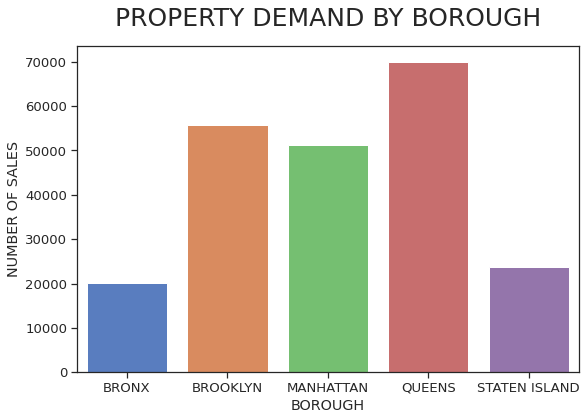

In [901]:
# Number of sales by borough
sales_by_borough_count = nyc_property_sales.groupby('BOROUGH')['SALE DATE'].count()
sales_by_borough = sales_by_borough_count.reset_index()

sns.barplot(x='BOROUGH', y= 'SALE DATE', data=sales_by_borough)
plt.ylabel('NUMBER OF SALES')
plt.title('PROPERTY DEMAND BY BOROUGH', fontsize=25, pad=20)
plt.show()

After some computation, I found that borough with the most property sales was Queens with 70,024 sales, followed by Brookylyn with 55,800 sales. Manhattan came in third with 51,325 sales and Staten Island fourth with 23752 sales. Bronx ranked last with only 20,039 property sales.

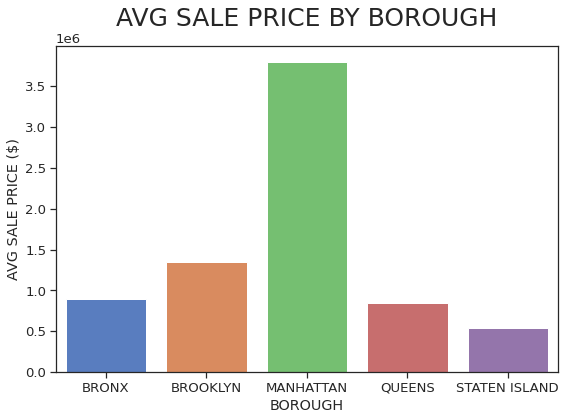

In [902]:
# Avg sale price by borough
mean_price_by_borough = nyc_property_sales.groupby('BOROUGH')['SALE PRICE'].mean()
mean_price_by_borough = mean_price_by_borough.reset_index()

sns.barplot(x='BOROUGH', y='SALE PRICE', data=mean_price_by_borough)
plt.title('AVG SALE PRICE BY BOROUGH', fontsize=25, pad=20)
plt.ylabel('AVG SALE PRICE ($)')
plt.show()

Although Queens saw the most demand, properties were most expensive in Manhattan. The average price of which properties sold for in Manhattan was \$3.8m while in Queens, the average price was \$850k. Staten Island was the cheapest with an average price of \$538k.

## What neigborhoods sold the most properties and at what price?

After determining the breakdown by boroughs, I wanted to know how the numbers looked when grouped by neigborhoods. I wanted to determine the number of sales and average property sale price across the most and least in-demand neigborhoods.

In [903]:
# Breakdown of sales count by neighborhood
nyc_property_sales.groupby('NEIGHBORHOOD')['SALE DATE'].count().reset_index().rename(columns={'SALE DATE':'COUNT'}).sort_values(by='COUNT', ascending=False)

,NEIGHBORHOOD,COUNT
90,FLUSHING-NORTH,6637
232,UPPER EAST SIDE (59-79),5317
233,UPPER EAST SIDE (79-96),4776
154,MIDTOWN EAST,3640
235,UPPER WEST SIDE (59-79),3519
...,...,...
50,CO-OP CITY,7
192,QUEENS-UNKNOWN,5
45,CITY ISLAND-PELHAM STRIP,4
95,FRESH KILLS,3


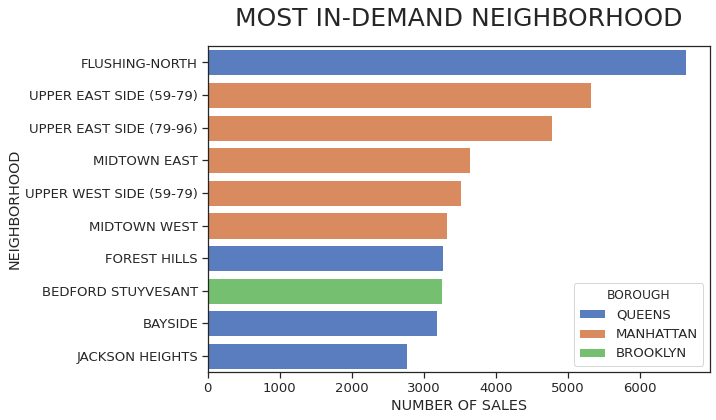

In [904]:
# Top 10 number of sales by neigborhood, color coded by borough
sales_by_neighborhood_count = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE DATE'].count()
sales_by_neighborhood = sales_by_neighborhood_count.reset_index()
sales_by_neighborhood.sort_values(by='SALE DATE', ascending=False, inplace=True)
sales_by_neighborhood.rename(columns={'SALE DATE':'COUNT'}, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
sales_by_neighborhood['BOROUGH'] = sales_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='COUNT', y='NEIGHBORHOOD', hue='BOROUGH', data=sales_by_neighborhood.head(10), dodge=False)
plt.xlabel('NUMBER OF SALES')
plt.title('MOST IN-DEMAND NEIGHBORHOOD', fontsize=25, pad=20)
plt.show()

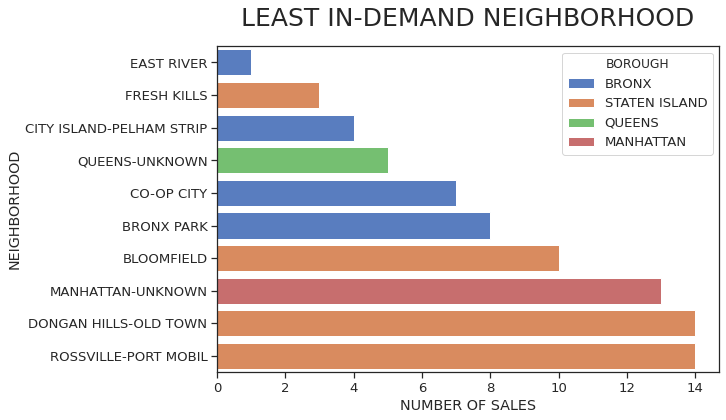

In [905]:
# Bottom 10 Number of Sales by Borough
sales_by_neighborhood_count = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE DATE'].count()
sales_by_neighborhood = sales_by_neighborhood_count.reset_index()
sales_by_neighborhood.sort_values(by='SALE DATE', ascending=True, inplace=True)
sales_by_neighborhood.rename(columns={'SALE DATE':'COUNT'}, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
sales_by_neighborhood['BOROUGH'] = sales_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='COUNT', y='NEIGHBORHOOD', hue='BOROUGH', data=sales_by_neighborhood.head(10), dodge=False)
plt.xlabel('NUMBER OF SALES')
plt.title('LEAST IN-DEMAND NEIGHBORHOOD', fontsize=25, pad=20)
plt.show()

The numbers of properties sold by neighborhood is pretty consistent with our previous analysis on the number of properties sold by borough. The top most in-demand neighborhoods were in Queens and Manhattan (ranked first and third in properties sold by borough) and the top least in-demand neigborhoods were in Bronx and Staten Island (ranked fifth and fourth in properties sold by borough).

In [906]:
# Breakdown of sale price by neighborhood
nyc_property_sales.groupby('NEIGHBORHOOD')['SALE PRICE'].count().reset_index().sort_values(by='SALE PRICE', ascending=False)

,NEIGHBORHOOD,SALE PRICE
90,FLUSHING-NORTH,6637
232,UPPER EAST SIDE (59-79),5317
233,UPPER EAST SIDE (79-96),4776
154,MIDTOWN EAST,3640
235,UPPER WEST SIDE (59-79),3519
...,...,...
50,CO-OP CITY,7
192,QUEENS-UNKNOWN,5
45,CITY ISLAND-PELHAM STRIP,4
95,FRESH KILLS,3


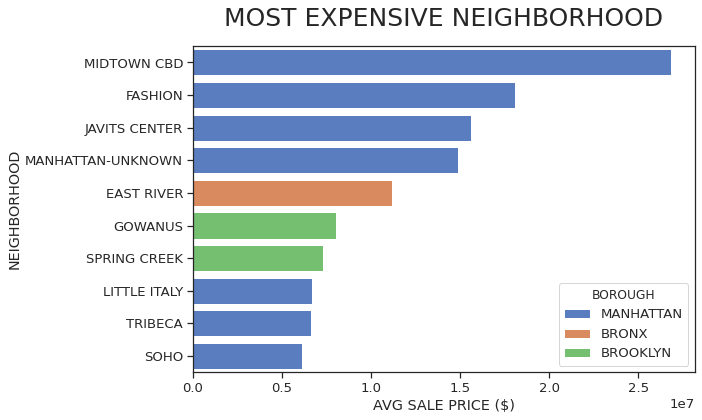

In [907]:
# Sale Price of Top 10 Neighborhoods
mean_price_by_neighborhood = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE PRICE'].mean()
mean_price_by_neighborhood = mean_price_by_neighborhood.reset_index()
mean_price_by_neighborhood.sort_values(by='SALE PRICE', ascending=False, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
mean_price_by_neighborhood['BOROUGH'] = mean_price_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='SALE PRICE', y='NEIGHBORHOOD', hue='BOROUGH', data=mean_price_by_neighborhood.head(10), dodge=False)
plt.title('MOST EXPENSIVE NEIGHBORHOOD', fontsize=25, pad=20)
plt.xlabel('AVG SALE PRICE ($)')
plt.show()

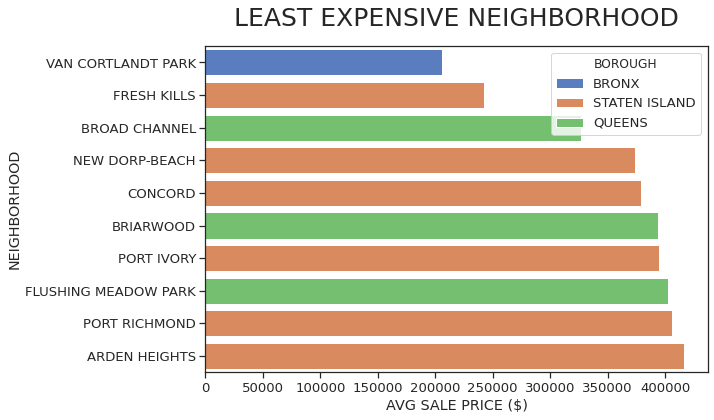

In [908]:
# Sale Price of Bottom 10 Neighborhoods
mean_price_by_neighborhood = nyc_property_sales.groupby('NEIGHBORHOOD')['SALE PRICE'].mean()
mean_price_by_neighborhood = mean_price_by_neighborhood.reset_index()
mean_price_by_neighborhood.sort_values(by='SALE PRICE', ascending=True, inplace=True)
pair_up = nyc_property_sales.drop_duplicates('NEIGHBORHOOD').set_index('NEIGHBORHOOD')['BOROUGH']
mean_price_by_neighborhood['BOROUGH'] = mean_price_by_neighborhood['NEIGHBORHOOD'].map(pair_up)

sns.barplot(x='SALE PRICE', y='NEIGHBORHOOD', hue='BOROUGH', data=mean_price_by_neighborhood.head(10), dodge=False)
plt.title('LEAST EXPENSIVE NEIGHBORHOOD', fontsize=25, pad=20)
plt.xlabel('AVG SALE PRICE ($)')
plt.show()

The average price of properties sold by neighborhood is also pretty consistent with the average price of properties sold by borough. 7 of the top 10 most expensive neigborhoods were in Manhattan which it valid because as we had found previously, Manhattan was indeed the most expensive borough. 7 of the top 10 least expensive neighorhoods were in Staten Island and Bronx which we also had classify previously as the cheaper boroughs. 

## What were the hottest buildings?

Now that we know the demand and price of properties, we can't help but wonder the type of buildings that these properties were. In this section, we examine for the most in-demand and most expensive building classes sold.

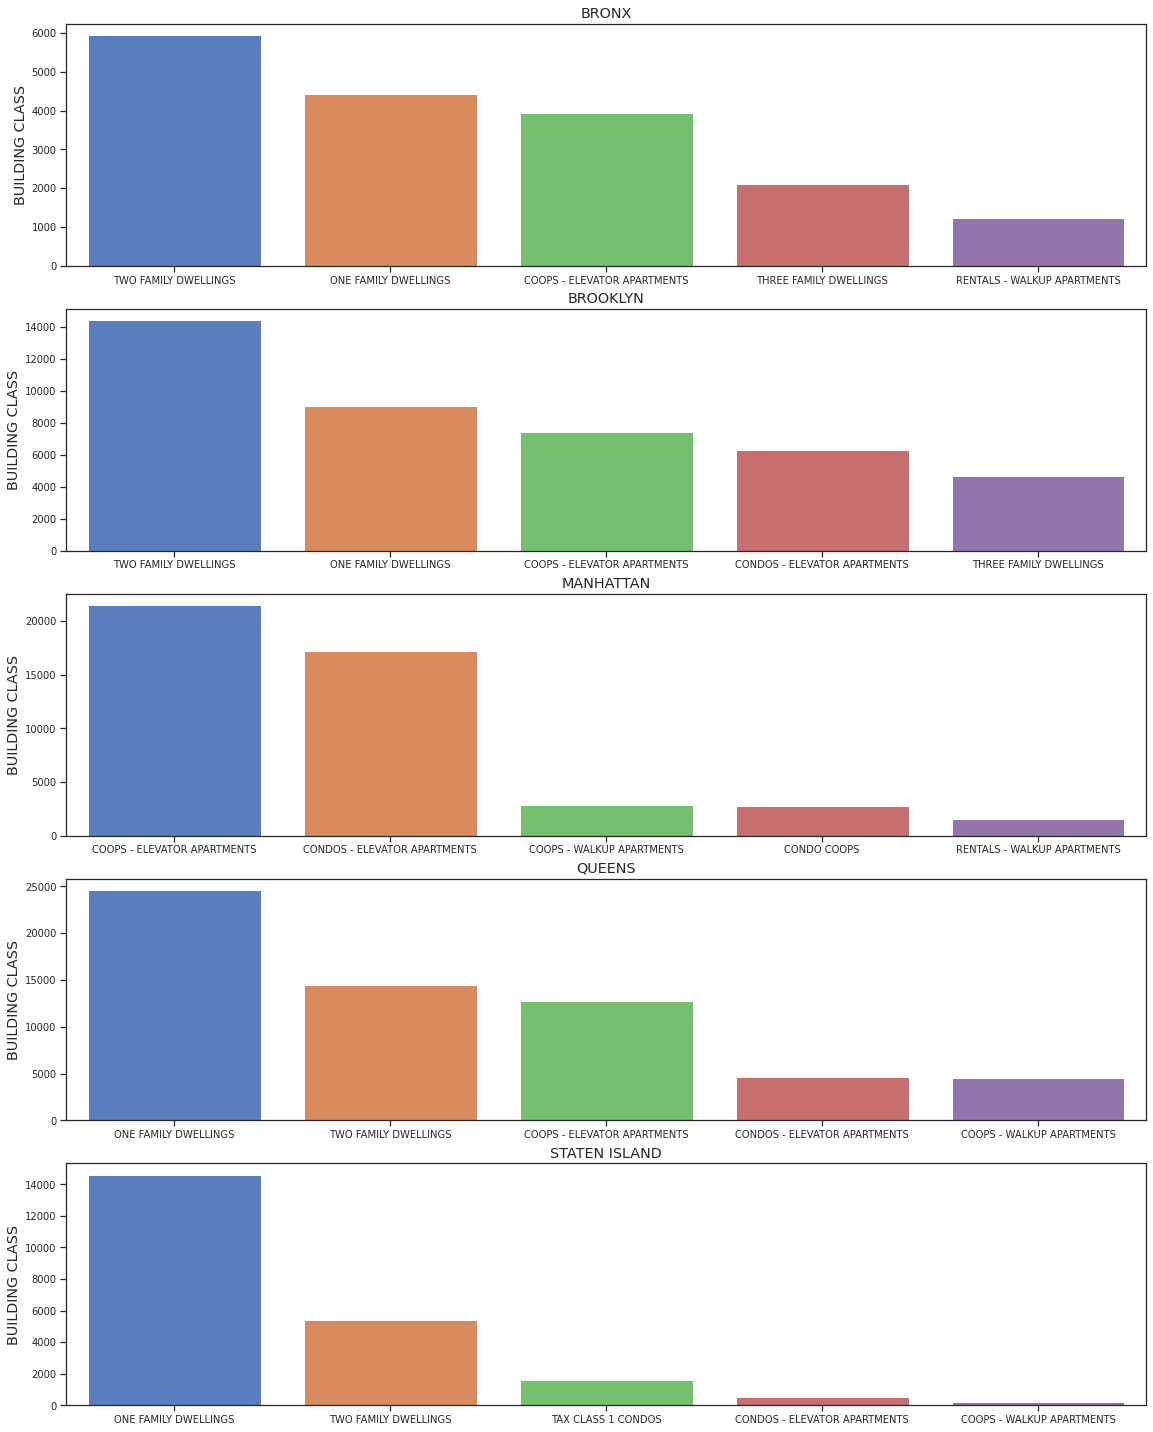

In [909]:
# Top 5 building classes in each borough 
building_by_borough = nyc_property_sales.groupby('BOROUGH')

fig, axes = plt.subplots(nrows=5, figsize=(16,20))
fig.tight_layout()

for i, group in enumerate(building_by_borough.groups):
  ax = axes[i]
  b = sns.barplot(y='BUILDING CLASS', x='index', data=building_by_borough.get_group(group)['BUILDING CLASS'].value_counts().head(5).reset_index(), ax=ax)
  b.set_xlabel('',fontsize=14)
  b.tick_params(labelsize=10)
  b.set_title(group)

fig.show()

The most in-demand building classes in the Bronx, Brooklyn, Queens and Staten Island were one/two family dwellings. This makes me think that these 4 boroughs have more space for larger homes and are more family oriented. Meanwhile in Manhattan, Coops and Condo are more popular which makes sense as space is more limited in the city.

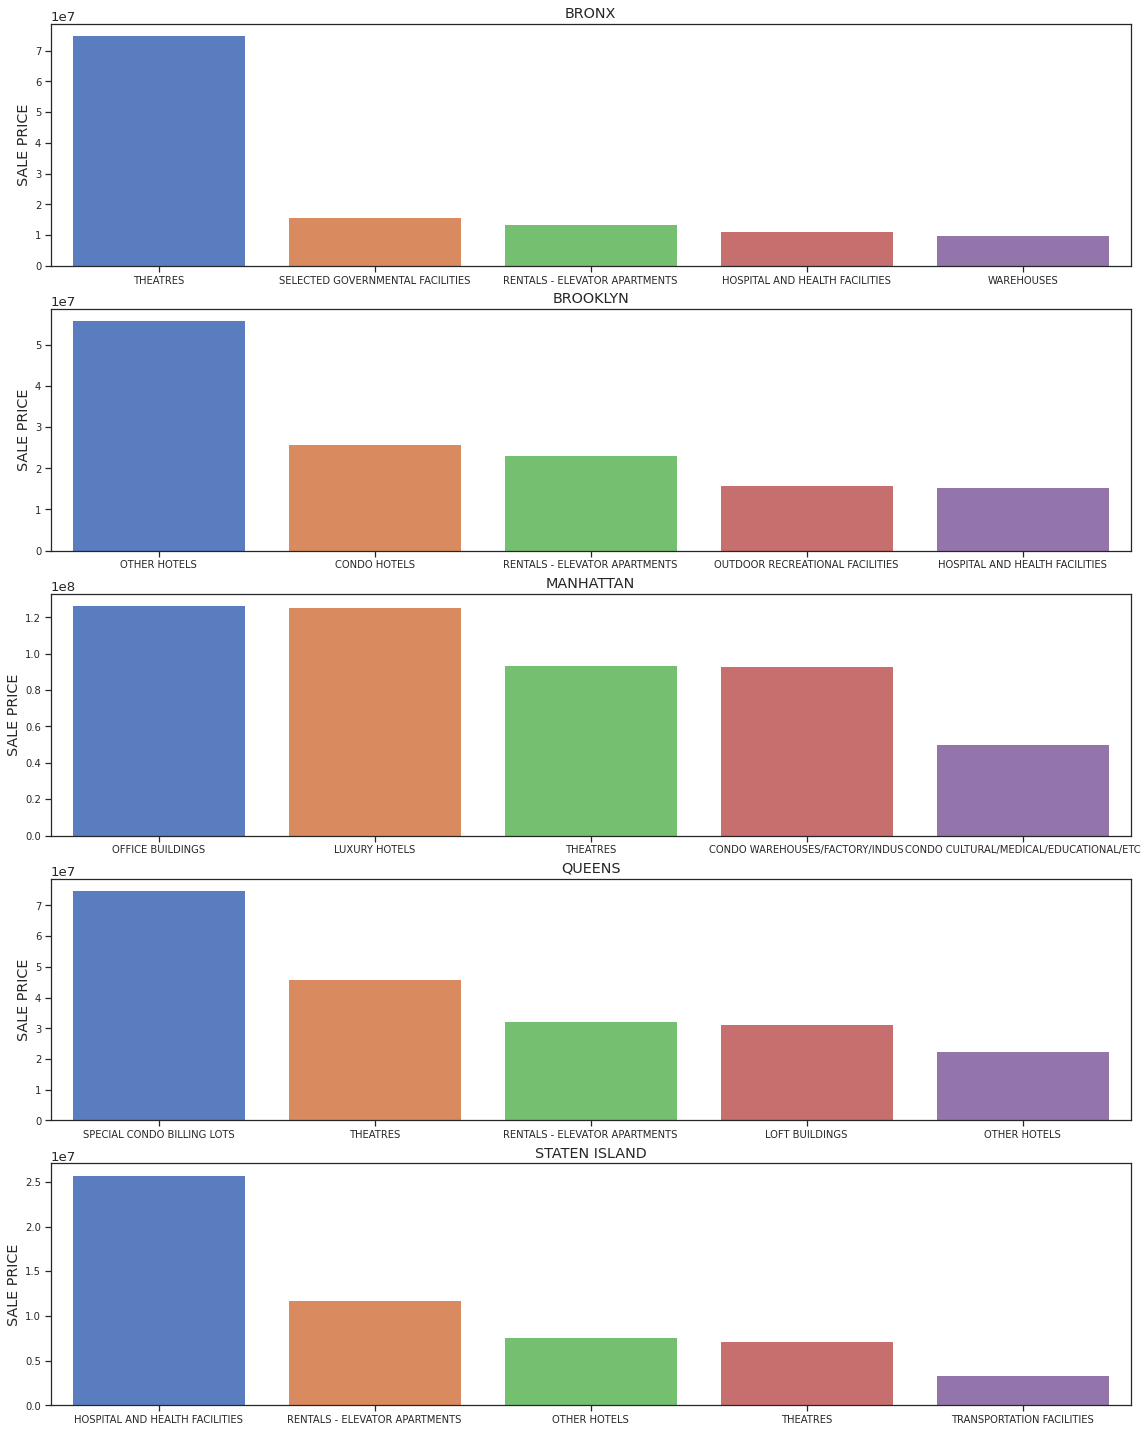

In [910]:
# Top 5 most expensive building classes in each borough
building_by_borough = nyc_property_sales.groupby('BOROUGH')

fig, axes = plt.subplots(nrows=5, figsize=(16,20))
fig.tight_layout()

for i, group in enumerate(building_by_borough.groups):
  ax = axes[i]
  building_by_borough_count = building_by_borough.get_group(group)['BUILDING CLASS'].value_counts()
  building_price_by_borough = building_by_borough.get_group(group).groupby('BUILDING CLASS')['SALE PRICE'].mean().reset_index()
  building_price_by_borough['COUNT'] = building_price_by_borough['BUILDING CLASS'].map(building_by_borough_count)
  b = sns.barplot(y='SALE PRICE', x='BUILDING CLASS', data=building_price_by_borough.sort_values(by='SALE PRICE', ascending=False).head(), ax=ax)
  b.set_xlabel('',fontsize=14)
  b.tick_params(labelsize=10)
  b.set_title(group)

fig.show()


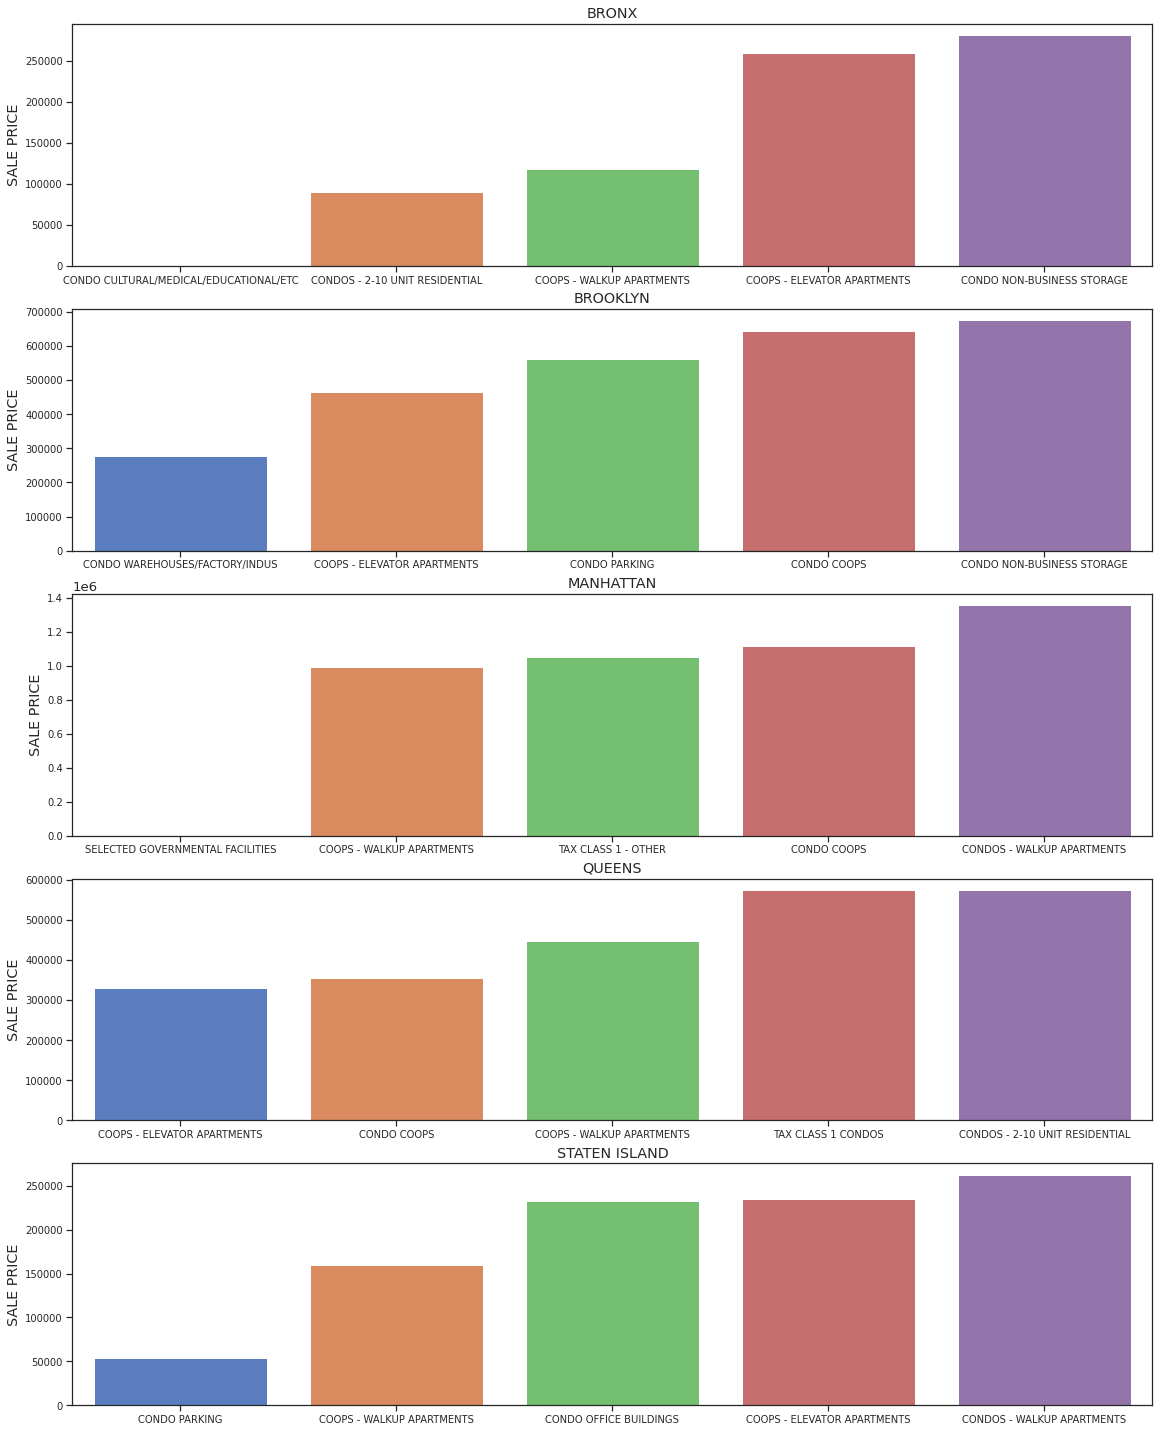

In [911]:
# Top 5 least expensive building classes in each borough
building_by_borough = nyc_property_sales.groupby('BOROUGH')

fig, axes = plt.subplots(nrows=5, figsize=(16,20))
fig.tight_layout()

for i, group in enumerate(building_by_borough.groups):
  ax = axes[i]
  building_by_borough_count = building_by_borough.get_group(group)['BUILDING CLASS'].value_counts()
  building_price_by_borough = building_by_borough.get_group(group).groupby('BUILDING CLASS')['SALE PRICE'].mean().reset_index()
  building_price_by_borough['COUNT'] = building_price_by_borough['BUILDING CLASS'].map(building_by_borough_count)
  b = sns.barplot(y='SALE PRICE', x='BUILDING CLASS', data=building_price_by_borough.sort_values(by='SALE PRICE', ascending=True).head(), ax=ax)
  b.set_xlabel('',fontsize=14)
  b.tick_params(labelsize=10)
  b.set_title(group)

fig.show()

Notice that the most expensive properties in each borough were commerical buildings such as theaters, hotels and office buildings while the least expensive properties were residental buildings such as Coops and Condos. Also notice that two government facilities with a sale price of $1 made it to the least expensive building class in Manhattan list. Details on the two buildings and their sales transaction are listed below. 

In [912]:
nyc_property_sales[(nyc_property_sales['BOROUGH']=='MANHATTAN')&(nyc_property_sales['BUILDING CLASS']=='SELECTED GOVERNMENTAL FACILITIES')]

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS,ADDRESS,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
90070,MANHATTAN,HARLEM-CENTRAL,SELECTED GOVERNMENTAL FACILITIES,120 EAST 125 STREET,10035,2523,8500,1950,1.0,2017-01-04
161911,MANHATTAN,LOWER EAST SIDE,SELECTED GOVERNMENTAL FACILITIES,269 HENRY STREET,10002,1962,6041,1900,1.0,2017-10-25


## What affects Sale Price?

Does land square feet affect sale price?

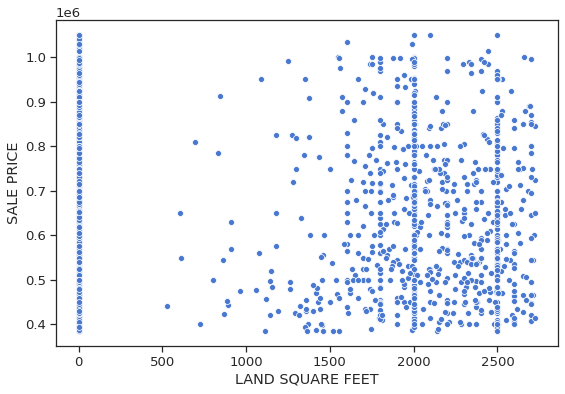

In [913]:
# Land square feet vs sale price
# For the plot, I excluded outliers (top and bottom 25%) and only graphed 20% of the population to it easier for the eyes.
price_and_sqft_cleaned = nyc_property_sales[(nyc_property_sales['SALE PRICE'].between(nyc_property_sales['SALE PRICE'].quantile(.25), nyc_property_sales['SALE PRICE'].quantile(.75))) & (nyc_property_sales['LAND SQUARE FEET'].between(nyc_property_sales['LAND SQUARE FEET'].quantile(.25), nyc_property_sales['LAND SQUARE FEET'].quantile(.75)))]
nyc_property_sales_sample = price_and_sqft_cleaned.sample(frac=0.02)

sns.scatterplot(x='LAND SQUARE FEET', y='SALE PRICE', data=nyc_property_sales_sample)
plt.show()

In [914]:
# correlation between sale price and land square feet
nyc_property_sales['SALE PRICE'].corr(nyc_property_sales['LAND SQUARE FEET'])

0.021909581170458412

There is almost no correlation (0.02 to be exact) between sale price and lands square feet.

So, what about gross square feet? Does that affect sale price?

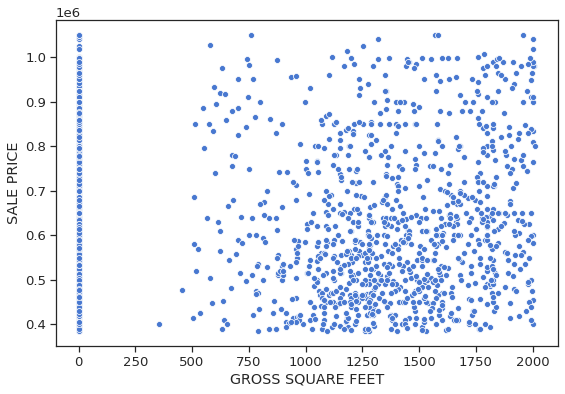

In [915]:
# Gross square feet vs sale price
# For the plot, I excluded outliers (top and bottom 25%) and only graphed 20% of the population to it easier for the eyes.
price_and_sqft_cleaned = nyc_property_sales[(nyc_property_sales['SALE PRICE'].between(nyc_property_sales['SALE PRICE'].quantile(.25), nyc_property_sales['SALE PRICE'].quantile(.75))) & (nyc_property_sales['GROSS SQUARE FEET'].between(nyc_property_sales['GROSS SQUARE FEET'].quantile(.25), nyc_property_sales['GROSS SQUARE FEET'].quantile(.75)))]
nyc_property_sales_sample = price_and_sqft_cleaned.sample(frac=0.02)

sns.scatterplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=nyc_property_sales_sample)
plt.show()

In [916]:
# correlation of sale price and gross square feet
nyc_property_sales['SALE PRICE'].corr(nyc_property_sales['GROSS SQUARE FEET'])

0.4604122820011419

Although not visible in the graph, gross square feet has a slight correlation with sale price. The correlation between the two is 0.46. This correlation is higher than the one we found with land square feet, which makes sense because gross square feet is usually higher than lands square feet. More floors and space means a higher price.

And what about the year in which the property was built? Does that affect sale price?

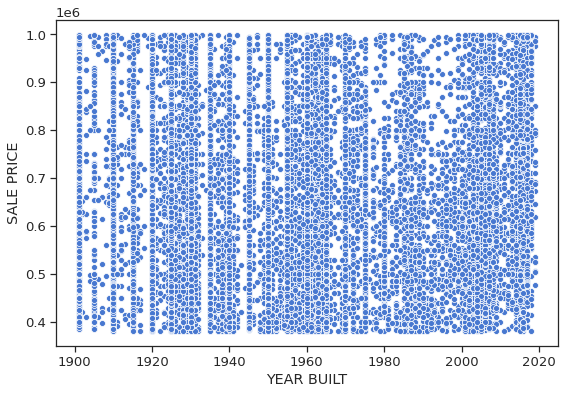

In [917]:
# Year built vs sale price
# For the plot, I excluded outliers (top and bottom 25%) and only graphed 20% of the population to it easier for the eyes.
year_built_cleaned = nyc_property_sales[nyc_property_sales['YEAR BUILT']>1900]
x = year_built_cleaned[year_built_cleaned['SALE PRICE'].between(year_built_cleaned['SALE PRICE'].quantile(.25), year_built_cleaned['SALE PRICE'].quantile(.75))]
year_built_cleaned_sample = x.sample(frac=0.2)

sns.scatterplot(x='YEAR BUILT', y='SALE PRICE', data=year_built_cleaned_sample)
plt.show()

In [918]:
# correlation of sale price and year built
nyc_property_sales['SALE PRICE'].corr(nyc_property_sales['YEAR BUILT'])

0.004102759021503975

There is no correlation between sale price and the year in which the property was built.